In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [5]:
df_alabama = pd.read_csv("data/Albama.csv")
df_california = pd.read_csv("data/California.csv")

In [6]:
# Combine datasets
df_pm25 = pd.concat([df_alabama, df_california], ignore_index=True)

In [7]:
### 🔹 Step 3: Aggregate PM2.5 by State + County
pm25_by_county = (
    df_pm25.groupby(['State', 'County'])['Daily Mean PM2.5 Concentration']
    .mean()
    .reset_index()
    .rename(columns={'Daily Mean PM2.5 Concentration': 'Average_PM2.5_2020'})
)

In [8]:
display(pm25_by_county.head())

,State,County,Average_PM2.5_2020
0,Alabama,Baldwin,7.846903
1,Alabama,Clay,6.835238
2,Alabama,DeKalb,7.174312
3,Alabama,Etowah,7.955752
4,Alabama,Jefferson,8.947880


In [9]:
np.random.seed(42)  # for reproducibility


In [10]:
pm25_by_county["Avg_Income_Bracket"] = np.random.randint(1, 6, size=len(pm25_by_county))
pm25_by_county["Wood_Usage_%"] = np.round(np.random.uniform(3, 20, size=len(pm25_by_county)), 2)


In [11]:
display(pm25_by_county.head())

,State,County,Average_PM2.5_2020,Avg_Income_Bracket,Wood_Usage_%
0,Alabama,Baldwin,7.846903,4,16.18
1,Alabama,Clay,6.835238,5,18.97
2,Alabama,DeKalb,7.174312,3,18.21
3,Alabama,Etowah,7.955752,5,13.16
4,Alabama,Jefferson,8.947880,5,18.67


In [12]:
# Priority Score = wood_usage × (6 - income_bracket) × PM2.5

pm25_by_county["Subsidy_Priority_Score"] = (
    pm25_by_county["Wood_Usage_%"]
    * (6 - pm25_by_county["Avg_Income_Bracket"])
    * pm25_by_county["Average_PM2.5_2020"]
).round(2)

In [13]:
display(pm25_by_county.sort_values("Subsidy_Priority_Score", ascending=False).head(10))

,State,County,Average_PM2.5_2020,Avg_Income_Bracket,Wood_Usage_%,Subsidy_Priority_Score
24,California,Inyo,16.884709,1,15.39,1299.28
18,California,Del Norte,9.060541,1,19.78,896.09
23,California,Imperial,10.892923,1,15.02,818.06
41,California,Riverside,10.202931,1,15.93,812.66
45,California,San Diego,12.589386,1,11.89,748.44
34,California,Mono,29.214356,3,8.53,747.60
63,California,Yolo,13.266005,2,13.77,730.69
61,California,Tulare,18.099693,4,18.80,680.55
25,California,Kern,13.760240,3,16.11,665.03
38,California,Orange,11.559615,1,11.03,637.51


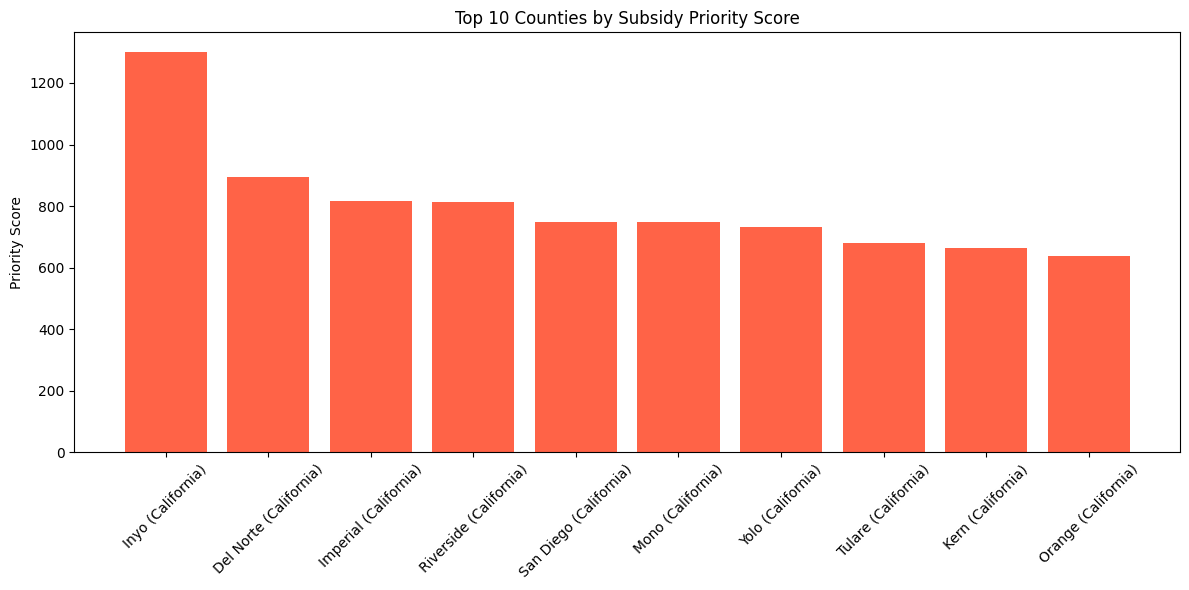

In [16]:
top10 = pm25_by_county.sort_values("Subsidy_Priority_Score", ascending=False).head(10)
plt.figure(figsize=(12,6))
plt.bar(top10["County"] + " (" + top10["State"] + ")", top10["Subsidy_Priority_Score"], color='tomato')
plt.xticks(rotation=45)
plt.title("Top 10 Counties by Subsidy Priority Score")
plt.ylabel("Priority Score")
plt.tight_layout()
plt.show()

In [18]:
# Features and target
X = pm25_by_county[["Wood_Usage_%", "Avg_Income_Bracket", "Average_PM2.5_2020"]]
y = pm25_by_county["Subsidy_Priority_Score"]


In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = DecisionTreeRegressor(max_depth=4, random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

In [21]:
y_pred = model.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R2 Score: 0.6645208230840388
Mean Squared Error: 16015.81203687683


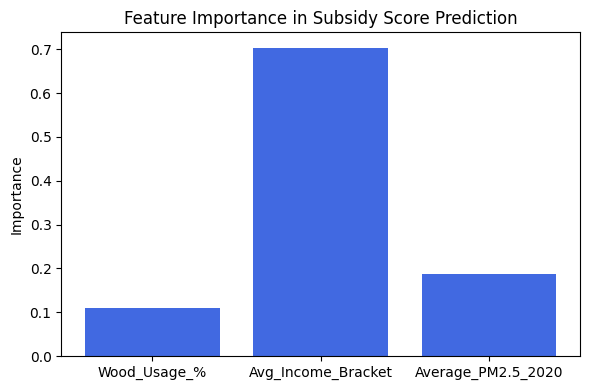

In [22]:
plt.figure(figsize=(6,4))
plt.bar(X.columns, model.feature_importances_, color='royalblue')
plt.title("Feature Importance in Subsidy Score Prediction")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [24]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [25]:
# Get predictions from all individual trees
all_tree_preds = [tree.predict(X_test) for tree in rf_model.estimators_]
all_tree_preds = np.array(all_tree_preds)


c:\Users\jaivb\Desktop\CSCN8040\pm2.5\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jaivb\Desktop\CSCN8040\pm2.5\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jaivb\Desktop\CSCN8040\pm2.5\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jaivb\Desktop\CSCN8040\pm2.5\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jaivb\Desktop\CSCN8040\pm2.5\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [26]:
# Mean and Std Deviation (uncertainty/confidence)
y_pred_mean = all_tree_preds.mean(axis=0)
y_pred_std = all_tree_preds.std(axis=0)  # Lower = more confident

In [27]:
# Create DataFrame with results
confidence_df = X_test.copy()
confidence_df["Actual"] = y_test.values
confidence_df["Predicted"] = y_pred_mean
confidence_df["Uncertainty (Std Dev)"] = y_pred_std


In [28]:
# Sort by uncertainty
confidence_df_sorted = confidence_df.sort_values("Uncertainty (Std Dev)", ascending=False)


In [29]:
confidence_df_sorted.head(10)

,Wood_Usage_%,Avg_Income_Bracket,Average_PM2.5_2020,Actual,Predicted,Uncertainty (Std Dev)
25,16.11,3,13.760240,665.03,433.6971,183.739800
40,15.13,4,18.159222,549.50,498.4201,162.829757
16,16.64,4,15.745224,524.00,394.4598,156.899930
61,18.80,4,18.099693,680.55,504.6524,149.614026
58,4.31,4,14.891441,128.36,162.9621,122.895388
36,13.84,3,10.332759,429.02,318.6310,90.952322
44,11.39,2,11.496827,523.80,405.6647,89.061023
56,15.84,4,8.269638,261.98,241.6652,75.793118
5,4.50,2,4.988889,89.80,185.2988,73.895460
0,16.18,4,7.846903,253.93,241.2860,71.158445


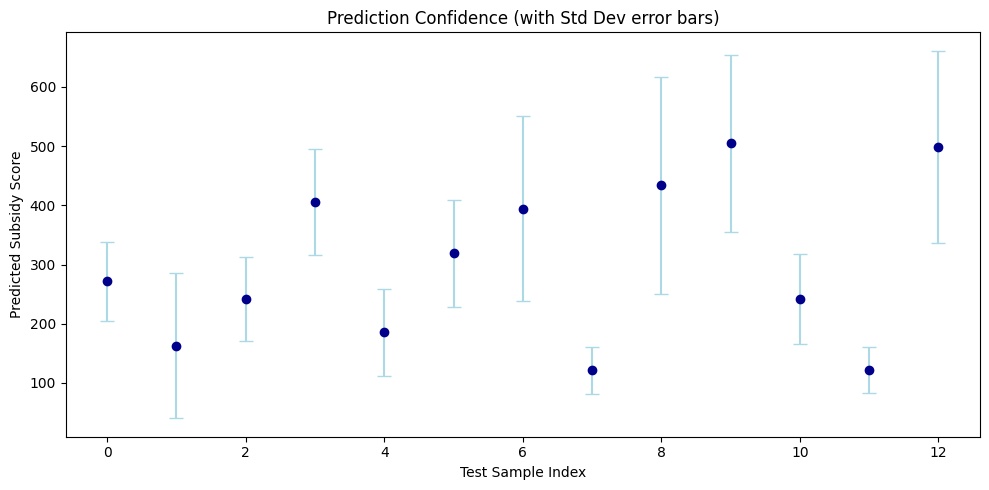

In [30]:
plt.figure(figsize=(10, 5))
plt.errorbar(range(len(y_pred_mean)), y_pred_mean, yerr=y_pred_std, fmt='o', color='darkblue', ecolor='lightblue', capsize=5)
plt.title("Prediction Confidence (with Std Dev error bars)")
plt.xlabel("Test Sample Index")
plt.ylabel("Predicted Subsidy Score")
plt.tight_layout()
plt.show()

In [31]:
# Add a confidence flag
confidence_df["Confidence Level"] = pd.cut(
    confidence_df["Uncertainty (Std Dev)"],
    bins=[-np.inf, 50, 150, np.inf],
    labels=["High", "Moderate", "Low"]
)

# View low-confidence predictions
confidence_df[confidence_df["Confidence Level"] == "Low"]


,Wood_Usage_%,Avg_Income_Bracket,Average_PM2.5_2020,Actual,Predicted,Uncertainty (Std Dev),Confidence Level
16,16.64,4,15.745224,524.00,394.4598,156.899930,Low
25,16.11,3,13.760240,665.03,433.6971,183.739800,Low
40,15.13,4,18.159222,549.50,498.4201,162.829757,Low


In [32]:
# View low-confidence predictions
confidence_df[confidence_df["Confidence Level"] == "Low"]

,Wood_Usage_%,Avg_Income_Bracket,Average_PM2.5_2020,Actual,Predicted,Uncertainty (Std Dev),Confidence Level
16,16.64,4,15.745224,524.00,394.4598,156.899930,Low
25,16.11,3,13.760240,665.03,433.6971,183.739800,Low
40,15.13,4,18.159222,549.50,498.4201,162.829757,Low
